### Importing of necessary libraries and initializing scientific constants

In [1]:
from scipy import constants
import numpy as np
import math
import matplotlib.pyplot as plt
import time 


#Defining the constants
c_0 = constants.speed_of_light
mu_0 = constants.mu_0
epsilon_0 = constants.epsilon_0


### Plotting Functions

In [2]:
def plot_single(x=0,y1=0,y2=0,size=[20,13],labels=["X-Axis","Y-Axis","Title"]):
    """
    Plot a vector in a single time step (snapshot in time)
    """
    plt.figure(figsize = size)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[2])
    plt.plot(x,y1)
    plt.plot(x,y2)
    plt.show()

def plot_fields(z,E_plot,H_plot,N_t,injection_point,title="",save=False):
    plt.ion()
    fig = plt.figure(1,[10,6])
    ax = fig.add_subplot(111)
    plt.ylabel("Value")
    
    _,x = E_plot.shape
    #for x in range(x):
    #    plt.axvline(x=x,ymin=0.3,ymax=0.7,color="forestgreen",linestyle = "-")
    #plt.axhline(y=2,color="forestgreen",linestyle = "-")
    plt.axhline(y=0,color="black",linestyle = "-")
    plt.axvline(x=injection_point, color = "grey", linestyle="--")
    plt.xlabel("z (Space)")
    plt.ylim((-5,5))
    #plt.xlim((0,x))
    lineE, = ax.plot(E_plot[0,:])
    lineH, = ax.plot(H_plot[0,:])
    fig.show()

    for i in range(1,N_t):
        plt.ylim(-5,5)
        plt.legend(handles = [lineE,lineH],labels=["Electric Field","Magnetic Field"])
        print(f"Currently plotting Iteration step: {i}/{N_t}")
        plt.title(f'FDTD 1-D {title} | Iteration step: {i}/{N_t}')
        if save == True:
            plt.savefig("/home/user/Desktop/photos/1d-fdtd{num:07d}.jpeg".format(num=i))
        lineE.set_ydata(E_plot[i,:])
        lineH.set_ydata(H_plot[i,:])
        fig.canvas.draw()
        fig.canvas.flush_events()

### User Input

In [3]:
#User Input
f_max = float(input("Enter the max frequency of the source excitation (in Hz): "))
mode = int(input("Enter the mode of FDTD Algorithm: \n(1) Basic Algorithm, No source excitation\n(2) Algorithm with Hard Source\n(3) Algorithm with Soft Source\n(4) Algorithm with Soft Source (with PABC)\n(5) Algorithm with TF/SF (with PABC):"))
source = int(input("Enter what source excitation to use: (1) Gaussian Pulse\n(2) Sinusoidal Source: "))
#NOTE: The assumption in this code is that the computational domain is composed of free-space
#There is no other material present in the domain so the material properties are that of the free space

Enter the max frequency of the source excitation (in Hz): 2.4E9
Enter the mode of FDTD Algorithm: 
(1) Basic Algorithm, No source excitation
(2) Algorithm with Hard Source
(3) Algorithm with Soft Source
(4) Algorithm with Soft Source (with PABC)
(5) Algorithm with TF/SF (with PABC):5
Enter what source excitation to use: (1) Gaussian Pulse
(2) Sinusoidal Source: 1


### Computing Grid Resolution (for preventing Numerical Dispersion)

In [4]:
#Computing Grid Resolution
n_max = 1 #Due to free space
lambda_min = c_0/(f_max*n_max)
N_lambda = 10
delta_lambda = lambda_min/N_lambda
d_min = 0.01
delta_d = d_min/4 #The d_min is assumed to be 0.01 since there is no device in the domain
delta_init = min(delta_lambda,delta_d)
#Since there is currently no critical dimension in the domain, assume it is 0.7
spacers = 15
#d_critical = 0.7
#N_z = math.ceil(d_critical/delta_init) + spacers
N_z = 500 + spacers
delta_z = delta_init
z = np.linspace(0,N_z*delta_z,N_z)
print("=====================================================================")
print(f"Number of Yee cells: {N_z} cells\nLength of each cell (Delta_z): {delta_z} m")

Number of Yee cells: 515 cells
Length of each cell (Delta_z): 0.0025 m


### Computing Material Properties
Assumed to be all free space at the moment

In [5]:
#Computing material properties
mu_r = np.ones((N_z))    #Due to free space
epsilon_r = np.ones((N_z))
n_r = np.sqrt(mu_r[0]*epsilon_r[0])

### Gaussian and Sinusoidal Source Functions

In [10]:
def gaussian_source(f_max,t_prop,delta_t,delta_z,c_0):
    """
    Gaussian Pulse Source that is used for injecting source in 1D FDTD.
    """
    #Set source permittivity and permeability
    mu_src =1 #these parameters should be the material permittivity/permeability at the grid position of the source injection
    epsilon_src = 1

    #Computing source parameters
    tau = 0.5/f_max
    t_0 = 5*tau
    T = 12*tau + 5*t_prop #Total time of simulation
    N_t = math.ceil(T/delta_t) #Number of time steps
    t = np.linspace(0,N_t*delta_t,N_t)
    print("=======================================================================")
    print(f"t_0 = {t_0} m, tau = {tau} m ")
    print(f"t = {t}")
    n_src = np.sqrt(epsilon_src*mu_src)
    deltaT = (n_src*delta_z/2*c_0)+(delta_t/2)

    A = -np.sqrt(epsilon_src/mu_src)
    x_E = (t - t_0)/tau
    x_H = ((t + deltaT)-t_0)/tau

    Esrc = np.exp(-np.power(x_E,2),dtype=np.longdouble).astype('longdouble')
    Hsrc = A*np.exp(-np.power(x_H,2),dtype=np.longdouble).astype('longdouble')
    return Esrc,Hsrc,t,N_t

def sinusoidal_source(f_max,t_prop,delta_t,delta_z,c_0):
    #Set source permittivity and permeability
    mu_src =1 #these parameters should be the material permittivity/permeability at the grid position of the source injection
    epsilon_src = 1

    #Computing source parameters
    tau = 3/f_max
    t_0 = 3*tau
    T = 12*tau + 5*t_prop #Total time of simulation
    N_t = math.ceil(T/delta_t) #Number of time steps
    t = np.linspace(0,N_t*delta_t,N_t)
    print(f"t = {t}")
    n_src = np.sqrt(epsilon_src*mu_src)
    deltaT = (n_src*delta_z/2*c_0)+(delta_t/2)

    A = -np.sqrt(epsilon_src/mu_src)

    n, = t.shape
    Esrc = np.zeros((t.shape))
    Hsrc = np.zeros((t.shape))
    for i in range(n):
        x_E = (t[i] - t_0)/tau
        x_H = (t[i]-t_0 + deltaT)/tau
        if t[i] < t_0:
            AmpE = np.exp(-np.power(x_E,2))
            AmpH = np.exp(-np.power(x_H,2))
            Esrc[i] = AmpE*(np.sin(2*np.pi*f_max*t[i]))
            Hsrc[i] = AmpH*A*(np.sin(2*np.pi*f_max*t[i]))
        else:
            Esrc[i] = AmpE*(np.sin(2*np.pi*f_max*t[i]))
            Hsrc[i] = AmpH*A*(np.sin(2*np.pi*f_max*t[i]))
    return Esrc,Hsrc,t,N_t

### Computing Time Step and Source (for preventing Numerical Dispersion)

t_0 = 1.0416666666666667e-09 m, tau = 2.0833333333333334e-10 m 
t = [0.00000000e+00 4.17027646e-12 8.34055291e-12 ... 2.39665788e-08
 2.39707491e-08 2.39749193e-08]
Time step: 4.169551189976901e-12 seconds
Number of iterations: 5750 steps
Time vector: (5750,) [Shape]
E-Field (Source):(5750,) dtype = float64, H-Field (Source): (5750,) dtype = float64
E=[1.38879439e-11 1.69589156e-11 2.06923669e-11 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00], H=[-0. -0. -0. ... -0. -0. -0.]


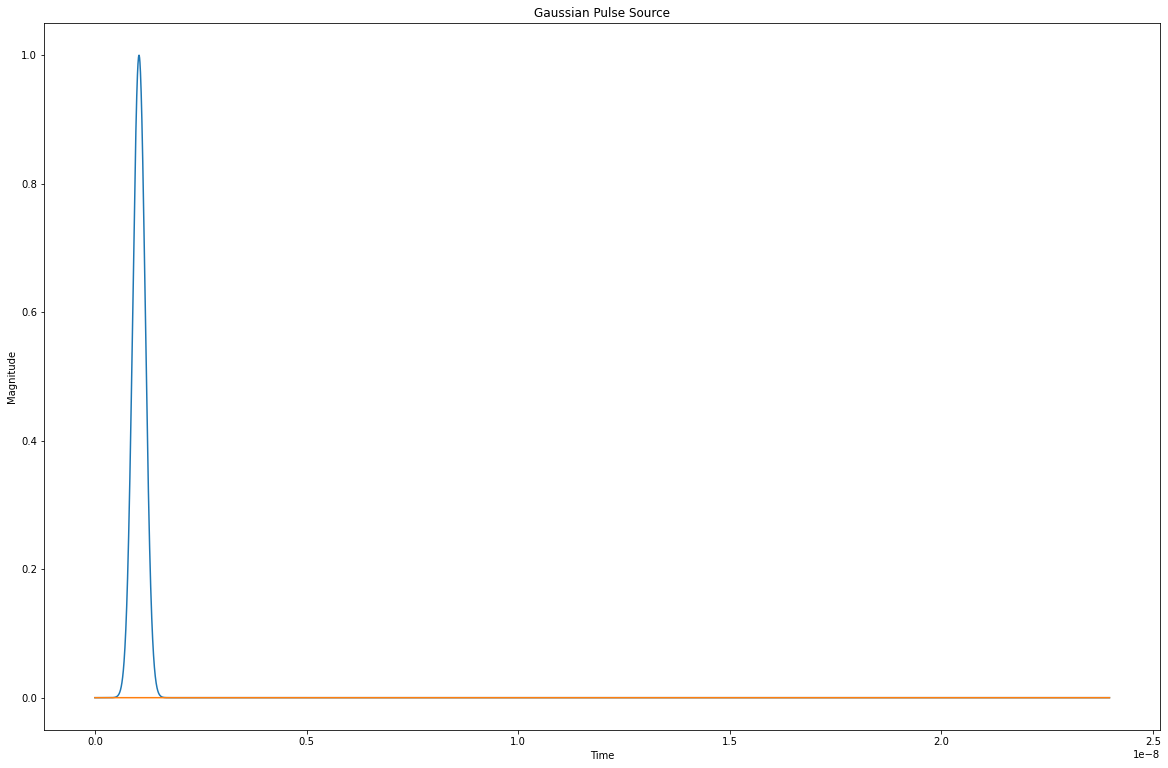

In [11]:
n_bc = 1 #Refractive index at the boundaries (assume free space) or min. refractive index in the domain
delta_t = (n_bc*delta_z)/(2*c_0) #Time step 
t_prop = (n_r*N_z*delta_z)/c_0 #time it takes to propagate in the domain

if source == 1:
    Esrc,Hsrc,t,N_t = gaussian_source(f_max,t_prop,delta_t,delta_z,c_0)
elif source == 2:
    Esrc,Hsrc,t,N_t = sinusoidal_source(f_max,t_prop,delta_t, delta_z, c_0)

injection_point = math.floor(N_z/4) #Set this before the device/model in the domain
print("=====================================================================")
print(f"Time step: {delta_t} seconds")
print(f"Number of iterations: {N_t} steps")
print(f"Time vector: {t.shape} [Shape]")
print(f"E-Field (Source):{Esrc.shape} dtype = {Esrc.dtype}, H-Field (Source): {Hsrc.shape} dtype = {Hsrc.dtype}")
print(f"E={Esrc}, H={Hsrc}")
if source == 1:
    plot_single(t,Esrc,Hsrc,labels=["Time","Magnitude","Gaussian Pulse Source"])
elif source == 2:
    plot_single(t,Esrc,Hsrc,labels=["Time","Magnitude","Sinusoidal Source"])

### Update coefficient computations and Field initialization

In [27]:
# Computing the update coefficients
m_E = c_0*delta_t/(epsilon_r*delta_z) #This is assuming that every cell is in free space
m_H = c_0*delta_t/(mu_r*delta_z)

#Field initialization
E = np.zeros((N_z),dtype=np.longdouble)
H = np.zeros((N_z),dtype=np.longdouble)
print("=====================================================================")
print(f"Update coefficients: m_E = {m_E.shape}, m_H = {m_H.shape}")
print(f"Field vectors: Ey: {E.shape} dtype = {E.dtype}, Hx: {H.shape} dtype = {H.dtype}")

#Initialize Boundary Terms (For Perfect Absorbing Boundary Conditions)
z_low = [0,0]
z_high = [0,0]
e2 = 0
h2 = 0

#Initialize save matrix
E_plot = np.zeros((N_t,N_z))
H_plot = np.zeros((N_t,N_z))

plot_title = ""

Update coefficients: m_E = (515,), m_H = (515,)
Field vectors: Ey: (515,), Hx: (515,)


In [16]:
if mode == 3: #Algorithm with Soft Source
    plot_title = "Soft Source"
    #Loop in time for Algorithm
    for i in range(N_t):
        #Update H from E (loop in space)
        for k in range(N_z -1): #Leave out the last cell @ index=N_z-1 for the boundary condition
            H[k] = H[k] + m_H[k]*(E[k+1] - E[k])
        #Dirichlet Boundary Condition for H at the end of the grid
        H[N_z-1] = H[N_z-1] + m_H[N_z-1]*(0 - E[N_z-1])

        #Dirichlet Boundary Condition for E at the start of the grid
        E[0] = E[0] + m_E[0]*(H[0]-0)
        #Update E from H (loop in space)
        for k in range(1,N_z):
            E[k] = E[k] + m_E[k]*(H[k]-H[k-1])

        #Inserting source excitation (Soft Source)
        E[injection_point] = E[injection_point] + Esrc[i]

        #Save into matrix
        E_plot[i,:] = E.reshape((1,N_z))
        H_plot[i,:] = H.reshape((1,N_z))
        print("=====================================================================")
        print(f"FDTD Algorithm {plot_title}: Successfully computed field values! iteration: {i}/{N_t}")
        
elif mode == 5: #Algorithm with TF/SF (with PABC)
    plot_title = "TF/SF with PABC"
    #Loop in time for Algorithm
    for i in range(N_t):

         #Record H at Boundary
        h2 = z_low.pop(0)
        z_low.append(H[0])

        #Update H from E (loop in space)
        for k in range(N_z -1): #Leave out the last cell @ index=N_z-1 for the boundary condition
            H[k] = H[k] + m_H[k]*(E[k+1] - E[k])
            
        #Adjustments for TF/SF
        #At k_injection - 1...
        H[injection_point-1] = H[injection_point-1] - m_H[injection_point-1]*Esrc[i]

        # Perfect Absorbing Boundary Condition for H at the end of the grid
        H[N_z-1] = H[N_z-1] + m_H[N_z-1]*(e2 - E[N_z-1])

        #Record E at Boundary
        e2 = z_high.pop(0)
        z_high.append(E[N_z-1])

        # Perfect Absorbing Boundary Condition for E at the start of the grid
        E[0] = E[0] + m_E[0]*(H[0]-h2)
        #Update E from H (loop in space)
        for k in range(1,N_z):
            E[k] = E[k] + m_E[k]*(H[k]-H[k-1])

        #Adjustment for the TF/SF
        E[injection_point] = E[injection_point] - m_E[injection_point]*Hsrc[i-1]
      
        
        
        #Save into matrix
        E_plot[i,:] = E.reshape((1,N_z))
        H_plot[i,:] = H.reshape((1,N_z))
        print("=====================================================================")
        print(f"FDTD Algorithm {plot_title}: Successfully computed field values! iteration: {i}/{N_t}")
        print(f"z_low:{z_low}")
        print(f"z_high:{z_high}")


FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 0/5750
z_low:[-3.269642821418081e-08, -3.6484962329372705e-08]
z_high:[1.0764152221885709e-08, 1.201477324891093e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1/5750
z_low:[-3.6484962329372705e-08, -4.06883026492303e-08]
z_high:[1.201477324891093e-08, 1.34029347180558e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2/5750
z_low:[-4.06883026492303e-08, -4.5349235664032277e-08]
z_high:[1.34029347180558e-08, 1.4942691513650756e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3/5750
z_low:[-4.5349235664032277e-08, -5.051456203055603e-08]
z_high:[1.4942691513650756e-08, 1.6649362885336315e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4/5750
z_low:[-5.051456203055603e-08, -5.623521361636025e-08]
z_high:[1.6649362885336315e-08, 1.8539799910745913e-08]
FDTD Algorithm TF/S

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 95/5750
z_low:[-6.936192699938955e-05, -7.287547254380053e-05]
z_high:[2.3217315146570252e-05, 2.4394780324138876e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 96/5750
z_low:[-7.287547254380053e-05, -7.651426211670388e-05]
z_high:[2.4394780324138876e-05, 2.5614240486344874e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 97/5750
z_low:[-7.651426211670388e-05, -8.02793018488909e-05]
z_high:[2.5614240486344874e-05, 2.6876029663906116e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 98/5750
z_low:[-8.02793018488909e-05, -8.417136363409014e-05]
z_high:[2.6876029663906116e-05, 2.818040238283484e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 99/5750
z_low:[-8.417136363409014e-05, -8.819096992294592e-05]
z_high:[2.818040238283484e-05, 2.9527528941707925e-05]
FDTD Algorithm

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 181/5750
z_low:[-0.0003330466409200152, -0.00032777005602127715]
z_high:[0.00011086593597136013, 0.00010908727502236765]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 182/5750
z_low:[-0.00032777005602127715, -0.0003223028047941973]
z_high:[0.00010908727502236765, 0.00010724549432329974]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 183/5750
z_low:[-0.0003223028047941973, -0.00031665646279619374]
z_high:[0.00010724549432329974, 0.00010534450151706416]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 184/5750
z_low:[-0.00031665646279619374, -0.00031084289731548643]
z_high:[0.00010534450151706416, 0.00010338829945622695]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 185/5750
z_low:[-0.00031084289731548643, -0.00030487422509009116]
z_high:[0.00010338829945622695, 0.00010138097233112211

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 271/5750
z_low:[-1.7809295112715945e-06, -1.6001142167994486e-06]
z_high:[5.713020861515653e-07, 5.129414579933263e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 272/5750
z_low:[-1.6001142167994486e-06, -1.4358605871965732e-06]
z_high:[5.129414579933263e-07, 4.599632471254612e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 273/5750
z_low:[-1.4358605871965732e-06, -1.2868479969210295e-06]
z_high:[4.599632471254612e-07, 4.119345166274985e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 274/5750
z_low:[-1.2868479969210295e-06, -1.1518408255897354e-06]
z_high:[4.119345166274985e-07, 3.684506020524411e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 275/5750
z_low:[-1.1518408255897354e-06, -1.0296849538651821e-06]
z_high:[3.684506020524411e-07, 3.291340659518269e-07]
FDTD 

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 370/5750
z_low:[5.649969649453442e-13, 1.0931320957161362e-13]
z_high:[4.721062714043587e-13, 6.177367847282258e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 371/5750
z_low:[1.0931320957161362e-13, -4.708180481854986e-13]
z_high:[6.177367847282258e-13, 1.634123001534958e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 372/5750
z_low:[-4.708180481854986e-13, -6.047016179849175e-13]
z_high:[1.634123001534958e-13, -4.545220647660335e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 373/5750
z_low:[-6.047016179849175e-13, -1.4612209170356605e-13]
z_high:[-4.545220647660335e-13, -6.285891827970577e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 374/5750
z_low:[-1.4612209170356605e-13, 4.721214666196563e-13]
z_high:[-6.285891827970577e-13, -1.7750014498606596e-13]
FDTD Algo

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 466/5750
z_low:[5.350407154532442e-11, 5.78716650954067e-11]
z_high:[6.929421818782851e-11, 7.508101190722341e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 467/5750
z_low:[5.78716650954067e-11, 6.205877505999498e-11]
z_high:[7.508101190722341e-11, 8.090793184905182e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 468/5750
z_low:[6.205877505999498e-11, 6.643958153686055e-11]
z_high:[8.090793184905182e-11, 8.674638076738074e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 469/5750
z_low:[6.643958153686055e-11, 7.151114452659826e-11]
z_high:[8.674638076738074e-11, 9.295437821434395e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 470/5750
z_low:[7.151114452659826e-11, 7.742912260736486e-11]
z_high:[9.295437821434395e-11, 9.994463143983707e-11]
FDTD Algorithm TF/SF with P

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 552/5750
z_low:[1.0327406401209356e-08, 1.1432113631262152e-08]
z_high:[2.537327734146282e-08, 2.910628890936125e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 553/5750
z_low:[1.1432113631262152e-08, 1.2709183383366235e-08]
z_high:[2.910628890936125e-08, 3.34698560413503e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 554/5750
z_low:[1.2709183383366235e-08, 1.4187721283850951e-08]
z_high:[3.34698560413503e-08, 3.857071008703982e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 555/5750
z_low:[1.4187721283850951e-08, 1.590145419394383e-08]
z_high:[3.857071008703982e-08, 4.453241999172144e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 556/5750
z_low:[1.590145419394383e-08, 1.7889805801139922e-08]
z_high:[4.453241999172144e-08, 5.1498271474065904e-08]
FDTD Algorithm TF/

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 636/5750
z_low:[0.00047843244547951215, 0.0005301908880858448]
z_high:[0.0016035737405838625, 0.0017750888991680364]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 637/5750
z_low:[0.0005301908880858448, 0.0005870891427813761]
z_high:[0.0017750888991680364, 0.0019634201924708244]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 638/5750
z_low:[0.0005870891427813761, 0.0006495848926919165]
z_high:[0.0019634201924708244, 0.002170042767753406]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 639/5750
z_low:[0.0006495848926919165, 0.0007181708697612083]
z_high:[0.002170042767753406, 0.0023965425836992415]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 640/5750
z_low:[0.0007181708697612083, 0.0007933769566711389]
z_high:[0.0023965425836992415, 0.002644622855351009]
FDTD Algorithm TF/SF with P

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 735/5750
z_low:[0.27304850289820665, 0.27979931616396675]
z_high:[0.835495286790114, 0.8555096051948647]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 736/5750
z_low:[0.27979931616396675, 0.28648781182902355]
z_high:[0.8555096051948647, 0.8753056673736858]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 737/5750
z_low:[0.28648781182902355, 0.2931016232180056]
z_high:[0.8753056673736858, 0.8948463494257014]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 738/5750
z_low:[0.2931016232180056, 0.2996282705885813]
z_high:[0.8948463494257014, 0.9140942891081123]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 739/5750
z_low:[0.2996282705885813, 0.3060551989816801]
z_high:[0.9140942891081123, 0.933012001203397]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 740

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 849/5750
z_low:[0.02444288492898011, 0.022836075233198392]
z_high:[0.06986425280039854, 0.06524160389402031]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 850/5750
z_low:[0.022836075233198392, 0.021317359766318527]
z_high:[0.06524160389402031, 0.06087488061942695]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 851/5750
z_low:[0.021317359766318527, 0.019883288944683594]
z_high:[0.06087488061942695, 0.056753860438530264]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 852/5750
z_low:[0.019883288944683594, 0.018530443083844356]
z_high:[0.056753860438530264, 0.052868427651287415]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 853/5750
z_low:[0.018530443083844356, 0.017255441150909063]
z_high:[0.052868427651287415, 0.04920859791010122]
FDTD Algorithm TF/SF with PABC: Successfully compute

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 973/5750
z_low:[9.457376035400317e-09, 7.966078922722481e-09]
z_high:[2.5913714763288677e-08, 2.18222516840859e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 974/5750
z_low:[7.966078922722481e-09, 6.704393919127508e-09]
z_high:[2.18222516840859e-08, 1.83605912570443e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 975/5750
z_low:[6.704393919127508e-09, 5.6377443850384205e-09]
z_high:[1.83605912570443e-08, 1.5434134477496342e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 976/5750
z_low:[5.6377443850384205e-09, 4.736320663023866e-09]
z_high:[1.5434134477496342e-08, 1.2962011356922124e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 977/5750
z_low:[4.736320663023866e-09, 3.974823627368822e-09]
z_high:[1.2962011356922124e-08, 1.0875221143213271e-08]
FDTD Algorithm TF/SF 

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1057/5750
z_low:[-3.835708623064176e-08, -4.203550513296316e-08]
z_high:[-1.266946874812698e-07, -1.3873252194694272e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1058/5750
z_low:[-4.203550513296316e-08, -4.603971396301922e-08]
z_high:[-1.3873252194694272e-07, -1.5182506367626077e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1059/5750
z_low:[-4.603971396301922e-08, -5.039503525895366e-08]
z_high:[-1.5182506367626077e-07, -1.6605487359210473e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1060/5750
z_low:[-5.039503525895366e-08, -5.5128855386392065e-08]
z_high:[-1.6605487359210473e-07, -1.81510045073398e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1061/5750
z_low:[-5.5128855386392065e-08, -6.027102286371253e-08]
z_high:[-1.81510045073398e-07, -1.982850563544084

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1170/5750
z_low:[-2.1332905270990198e-05, -2.16902283776902e-05]
z_high:[-6.481455155431036e-05, -6.585497504631044e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1171/5750
z_low:[-2.16902283776902e-05, -2.2036855105490967e-05]
z_high:[-6.585497504631044e-05, -6.68615424951108e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1172/5750
z_low:[-2.2036855105490967e-05, -2.237203704900565e-05]
z_high:[-6.68615424951108e-05, -6.783205663977555e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1173/5750
z_low:[-2.237203704900565e-05, -2.2695038148629812e-05]
z_high:[-6.783205663977555e-05, -6.876436223872077e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1174/5750
z_low:[-2.2695038148629812e-05, -2.3005137510310732e-05]
z_high:[-6.876436223872077e-05, -6.965635444001561e-05

z_high:[-8.430068730200605e-06, -7.890960607603657e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1263/5750
z_low:[-2.759719857566329e-06, -2.58203343573781e-06]
z_high:[-7.890960607603657e-06, -7.378288573802533e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1264/5750
z_low:[-2.58203343573781e-06, -2.41314095452548e-06]
z_high:[-7.378288573802533e-06, -6.891370905066132e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1265/5750
z_low:[-2.41314095452548e-06, -2.2528109990351917e-06]
z_high:[-6.891370905066132e-06, -6.429497704057739e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1266/5750
z_low:[-2.2528109990351917e-06, -2.1008031513216315e-06]
z_high:[-6.429497704057739e-06, -5.991935221878195e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1267/5750
z_low:[-2.1008031513216315e-06, -1.956868819475677e-06]


FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1357/5750
z_low:[-8.378198285676758e-12, -6.351139479313062e-12]
z_high:[-2.4112976132411544e-11, -1.8232299086734166e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1358/5750
z_low:[-6.351139479313062e-12, -5.368741891217752e-12]
z_high:[-1.8232299086734166e-11, -1.416229411297128e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1359/5750
z_low:[-5.368741891217752e-12, -4.814595893566287e-12]
z_high:[-1.416229411297128e-11, -1.1551410775633548e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1360/5750
z_low:[-4.814595893566287e-12, -4.0171047740868825e-12]
z_high:[-1.1551410775633548e-11, -9.565117795055533e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1361/5750
z_low:[-4.0171047740868825e-12, -2.7905538043416083e-12]
z_high:[-9.565117795055533e-12, -7.4924596293356

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1453/5750
z_low:[2.2433916339248426e-13, -4.625736256174137e-14]
z_high:[1.0079874995053642e-12, 1.1353372412153111e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1454/5750
z_low:[-4.625736256174137e-14, -6.500981163259167e-13]
z_high:[1.1353372412153111e-12, 5.362508081153423e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1455/5750
z_low:[-6.500981163259167e-13, -1.0699289998475842e-12]
z_high:[5.362508081153423e-13, -1.8018245281232103e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1456/5750
z_low:[-1.0699289998475842e-12, -9.860538860695473e-13]
z_high:[-1.8018245281232103e-13, -3.2062785359553217e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1457/5750
z_low:[-9.860538860695473e-13, -5.494657618120031e-13]
z_high:[-3.2062785359553217e-13, 2.5371455707900384e-

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1548/5750
z_low:[-3.565185063063421e-10, -3.7643077488465256e-10]
z_high:[3.075070740761977e-10, 3.2394745985094124e-10]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1549/5750
z_low:[-3.7643077488465256e-10, -3.985392479849716e-10]
z_high:[3.2394745985094124e-10, 3.3994940249543725e-10]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1550/5750
z_low:[-3.985392479849716e-10, -4.2201059486346804e-10]
z_high:[3.3994940249543725e-10, 3.5592044134614374e-10]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1551/5750
z_low:[-4.2201059486346804e-10, -4.461531651496756e-10]
z_high:[3.5592044134614374e-10, 3.7306784589722136e-10]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1552/5750
z_low:[-4.461531651496756e-10, -4.71253039528245e-10]
z_high:[3.7306784589722136e-10, 3.923140173292298e-10]

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1652/5750
z_low:[-8.62450590373921e-05, -9.61678489124185e-05]
z_high:[2.8418439834850857e-05, 3.169895797957476e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1653/5750
z_low:[-9.61678489124185e-05, -0.00010715400564284837]
z_high:[3.169895797957476e-05, 3.5332229570203965e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1654/5750
z_low:[-0.00010715400564284837, -0.00011930799685848354]
z_high:[3.5332229570203965e-05, 3.9353030980320794e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1655/5750
z_low:[-0.00011930799685848354, -0.00013274346136688578]
z_high:[3.9353030980320794e-05, 4.379920240165374e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1656/5750
z_low:[-0.00013274346136688578, -0.00014758389459410971]
z_high:[4.379920240165374e-05, 4.8711878217186075e-05]


FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1766/5750
z_low:[-0.17216844001500922, -0.1761012737313292]
z_high:[0.05765218197517671, 0.05896606753221764]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1767/5750
z_low:[-0.1761012737313292, -0.1799822581461328]
z_high:[0.05896606753221764, 0.060262266645339325]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1768/5750
z_low:[-0.1799822581461328, -0.1838039737614535]
z_high:[0.060262266645339325, 0.0615382861668634]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1769/5750
z_low:[-0.1838039737614535, -0.18755897520513432]
z_high:[0.0615382861668634, 0.06279162524900059]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1770/5750
z_low:[-0.18755897520513432, -0.1912398145724918]
z_high:[0.06279162524900059, 0.06401978323704514]
FDTD Algorithm TF/SF with PABC: Successfully computed fie

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1871/5750
z_low:[-0.02244421550933524, -0.021065837214587192]
z_high:[0.0073528076909143494, 0.006898744339262992]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1872/5750
z_low:[-0.021065837214587192, -0.019755237367659904]
z_high:[0.006898744339262992, 0.006467179376563995]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1873/5750
z_low:[-0.019755237367659904, -0.01851035324426505]
z_high:[0.006467179376563995, 0.0060574169442357455]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1874/5750
z_low:[-0.01851035324426505, -0.017329090824354177]
z_high:[0.0060574169442357455, 0.005668751584018294]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1875/5750
z_low:[-0.017329090824354177, -0.01620933343132657]
z_high:[0.005668751584018294, 0.005300471101105795]
FDTD Algorithm TF/SF with PABC:

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1969/5750
z_low:[-6.952746809987655e-07, -5.980460011535366e-07]
z_high:[2.1695916401560472e-07, 1.8650195421191576e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1970/5750
z_low:[-5.980460011535366e-07, -5.139360046281724e-07]
z_high:[1.8650195421191576e-07, 1.601711165288695e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1971/5750
z_low:[-5.139360046281724e-07, -4.4124471139448944e-07]
z_high:[1.601711165288695e-07, 1.374291219419836e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1972/5750
z_low:[-4.4124471139448944e-07, -3.7848220621981145e-07]
z_high:[1.374291219419836e-07, 1.1780562138811204e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 1973/5750
z_low:[-3.7848220621981145e-07, -3.2434427116180943e-07]
z_high:[1.1780562138811204e-07, 1.008895934268656e-07]


FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2062/5750
z_low:[2.564002204656496e-09, 2.841752486060623e-09]
z_high:[-8.470343754301574e-10, -9.391665626929226e-10]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2063/5750
z_low:[2.841752486060623e-09, 3.14831864552747e-09]
z_high:[-9.391665626929226e-10, -1.0402418890835822e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2064/5750
z_low:[3.14831864552747e-09, 3.4858697039015777e-09]
z_high:[-1.0402418890835822e-09, -1.15140619529027e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2065/5750
z_low:[3.4858697039015777e-09, 3.856902927607624e-09]
z_high:[-1.15140619529027e-09, -1.2741208778895096e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2066/5750
z_low:[3.856902927607624e-09, 4.26468261291786e-09]
z_high:[-1.2741208778895096e-09, -1.4096795409775224e-09]
FDTD Alg

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2164/5750
z_low:[4.575077521752446e-06, 4.767675957442372e-06]
z_high:[-1.5320453429229428e-06, -1.5965827189762945e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2165/5750
z_low:[4.767675957442372e-06, 4.965028321367825e-06]
z_high:[-1.5965827189762945e-06, -1.662711158298542e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2166/5750
z_low:[4.965028321367825e-06, 5.167050262027627e-06]
z_high:[-1.662711158298542e-06, -1.7304014851138463e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2167/5750
z_low:[5.167050262027627e-06, 5.373642590629161e-06]
z_high:[-1.7304014851138463e-06, -1.799620282764955e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2168/5750
z_low:[5.373642590629161e-06, 5.584691396847838e-06]
z_high:[-1.799620282764955e-06, -1.8703297100307004e-06]
FDTD

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2264/5750
z_low:[6.962925126966523e-06, 6.7003480947194344e-06]
z_high:[-2.3033933685484245e-06, -2.215826940147418e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2265/5750
z_low:[6.7003480947194344e-06, 6.4413914939291666e-06]
z_high:[-2.215826940147418e-06, -2.129501064544923e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2266/5750
z_low:[6.4413914939291666e-06, 6.186377646965331e-06]
z_high:[-2.129501064544923e-06, -2.0445222784492563e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2267/5750
z_low:[6.186377646965331e-06, 5.935608123460396e-06]
z_high:[-2.0445222784492563e-06, -1.9609905569104266e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2268/5750
z_low:[5.935608123460396e-06, 5.689363744881702e-06]
z_high:[-1.9609905569104266e-06, -1.8789989359682156e-06]


FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2369/5750
z_low:[8.301053926463724e-11, 6.634328976169931e-11]
z_high:[-2.537421853432722e-11, -2.0458599373060045e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2370/5750
z_low:[6.634328976169931e-11, 5.330019309556458e-11]
z_high:[-2.0458599373060045e-11, -1.5714847553374682e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2371/5750
z_low:[5.330019309556458e-11, 4.236752909634163e-11]
z_high:[-1.5714847553374682e-11, -1.1519596826522386e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2372/5750
z_low:[4.236752909634163e-11, 3.268285120616101e-11]
z_high:[-1.1519596826522386e-11, -8.515798693549463e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2373/5750
z_low:[3.268285120616101e-11, 2.43808252266236e-11]
z_high:[-8.515798693549463e-12, -6.834976851052254e-12]
FDTD 

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2465/5750
z_low:[-5.215987447410315e-13, -1.1249824296563688e-12]
z_high:[4.441206538170082e-13, -5.078425045085892e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2466/5750
z_low:[-1.1249824296563688e-12, -6.910116124871297e-13]
z_high:[-5.078425045085892e-13, -9.47257160814024e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2467/5750
z_low:[-6.910116124871297e-13, 3.4550553482993677e-13]
z_high:[-9.47257160814024e-13, -4.754433750418599e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2468/5750
z_low:[3.4550553482993677e-13, 1.001393824478513e-12]
z_high:[-4.754433750418599e-13, 4.124877632701732e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2469/5750
z_low:[1.001393824478513e-12, 6.843624232983472e-13]
z_high:[4.124877632701732e-13, 8.328429319907378e-13]
FDTD Al

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2567/5750
z_low:[-3.568753031303564e-11, -3.8141456091050604e-11]
z_high:[-4.3815471128820985e-11, -4.616818205907006e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2568/5750
z_low:[-3.8141456091050604e-11, -4.075098442732537e-11]
z_high:[-4.616818205907006e-11, -4.923677783061959e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2569/5750
z_low:[-4.075098442732537e-11, -4.304611415211977e-11]
z_high:[-4.923677783061959e-11, -5.262606320559918e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2570/5750
z_low:[-4.304611415211977e-11, -4.492990466066404e-11]
z_high:[-5.262606320559918e-11, -5.580730766075224e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2571/5750
z_low:[-4.492990466066404e-11, -4.677578866224815e-11]
z_high:[-5.580730766075224e-11, -5.86222116530535e-11

z_low:[-1.2301615895211584e-07, -1.399512566687598e-07]
z_high:[-4.2870344393773145e-07, -4.872965174511157e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2649/5750
z_low:[-1.399512566687598e-07, -1.5911584763752518e-07]
z_high:[-4.872965174511157e-07, -5.535312116402023e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2650/5750
z_low:[-1.5911584763752518e-07, -1.8078845544723144e-07]
z_high:[-5.535312116402023e-07, -6.283510723546231e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2651/5750
z_low:[-1.8078845544723144e-07, -2.052805552836962e-07]
z_high:[-6.283510723546231e-07, -7.128095093241383e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2652/5750
z_low:[-2.052805552836962e-07, -2.329396730190024e-07]
z_high:[-7.128095093241383e-07, -8.080814005055444e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2653

z_high:[-0.001028874096382294, -0.0011093931596323425]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2725/5750
z_low:[-0.00034303302505940195, -0.000369941796054626]
z_high:[-0.0011093931596323425, -0.0011953521754170487]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2726/5750
z_low:[-0.000369941796054626, -0.00039867281194111854]
z_high:[-0.0011953521754170487, -0.0012870431405366536]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2727/5750
z_low:[-0.00039867281194111854, -0.00042932411452514314]
z_high:[-0.0012870431405366536, -0.0013847674931143947]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2728/5750
z_low:[-0.00042932411452514314, -0.0004619969242759305]
z_high:[-0.0013847674931143947, -0.0014888359076029869]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2729/5750
z_low:[-0.0004619969242759305, -0.0004967955719575042

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2806/5750
z_low:[-0.013989800485143552, -0.014192740284456115]
z_high:[-0.042417227974295126, -0.04300225583375896]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2807/5750
z_low:[-0.014192740284456115, -0.01438726095847243]
z_high:[-0.04300225583375896, -0.043561041906965595]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2808/5750
z_low:[-0.01438726095847243, -0.01457292427516323]
z_high:[-0.043561041906965595, -0.044092318286035]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2809/5750
z_low:[-0.01457292427516323, -0.01474930671488197]
z_high:[-0.044092318286035, -0.04459486482421361]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2810/5750
z_low:[-0.01474930671488197, -0.014916001056122471]
z_high:[-0.04459486482421361, -0.045067513741450835]
FDTD Algorithm TF/SF with PABC: Succ

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2885/5750
z_low:[-0.0035380296412269242, -0.003361534746106266]
z_high:[-0.010212286083746911, -0.009697589744987264]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2886/5750
z_low:[-0.003361534746106266, -0.0031910473214508354]
z_high:[-0.009697589744987264, -0.009200787595402727]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2887/5750
z_low:[-0.0031910473214508354, -0.00302654985304155]
z_high:[-0.009200787595402727, -0.00872179771005144]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2888/5750
z_low:[-0.00302654985304155, -0.002868010980492884]
z_high:[-0.00872179771005144, -0.008260498635797245]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2889/5750
z_low:[-0.002868010980492884, -0.0027153862759071597]
z_high:[-0.008260498635797245, -0.007816731738999974]
FDTD Algorithm TF/SF

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2967/5750
z_low:[-2.5668811571495573e-06, -2.259017551388417e-06]
z_high:[-7.1334963354001455e-06, -6.275536034333451e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2968/5750
z_low:[-2.259017551388417e-06, -1.9860907710059026e-06]
z_high:[-6.275536034333451e-06, -5.51525470416434e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2969/5750
z_low:[-1.9860907710059026e-06, -1.7443895227096119e-06]
z_high:[-5.51525470416434e-06, -4.8422361043376465e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2970/5750
z_low:[-1.7443895227096119e-06, -1.530565085835764e-06]
z_high:[-4.8422361043376465e-06, -4.247087620012136e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 2971/5750
z_low:[-1.530565085835764e-06, -1.341600138598381e-06]
z_high:[-4.247087620012136e-06, -3.721349869531060

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3042/5750
z_low:[-8.418635429665473e-12, -6.91036259606782e-12]
z_high:[-2.357048420524393e-11, -1.8157376653783154e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3043/5750
z_low:[-6.91036259606782e-12, -5.872873145288924e-12]
z_high:[-1.8157376653783154e-11, -1.410733851117276e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3044/5750
z_low:[-5.872873145288924e-12, -4.73107488497802e-12]
z_high:[-1.410733851117276e-11, -1.089773464569961e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3045/5750
z_low:[-4.73107488497802e-12, -3.280324194169971e-12]
z_high:[-1.089773464569961e-11, -7.929362799676194e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3046/5750
z_low:[-3.280324194169971e-12, -1.812189562851109e-12]
z_high:[-7.929362799676194e-12, -4.963308233813113e-12]
FD

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3129/5750
z_low:[5.7656175073977705e-09, 6.248957064567511e-09]
z_high:[1.8773058169127076e-08, 2.0331391813518855e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3130/5750
z_low:[6.248957064567511e-09, 6.769198549831347e-09]
z_high:[2.0331391813518855e-08, 2.200711009046505e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3131/5750
z_low:[6.769198549831347e-09, 7.328429049557963e-09]
z_high:[2.200711009046505e-08, 2.3807751029960793e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3132/5750
z_low:[7.328429049557963e-09, 7.928920638827476e-09]
z_high:[2.3807751029960793e-08, 2.5740861192610657e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3133/5750
z_low:[7.928920638827476e-09, 8.57343728497443e-09]
z_high:[2.5740861192610657e-08, 2.7814455762796026e-08]
FDTD Algorit

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3213/5750
z_low:[6.019449157824126e-07, 6.188475933736113e-07]
z_high:[1.8480307284068306e-06, 1.8986360514791002e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3214/5750
z_low:[6.188475933736113e-07, 6.357776598880788e-07]
z_high:[1.8986360514791002e-06, 1.949254280270281e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3215/5750
z_low:[6.357776598880788e-07, 6.527104162900081e-07]
z_high:[1.949254280270281e-06, 1.9998098981517464e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3216/5750
z_low:[6.527104162900081e-07, 6.696195371483689e-07]
z_high:[1.9998098981517464e-06, 2.0502245336330773e-06]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3217/5750
z_low:[6.696195371483689e-07, 6.864776990714932e-07]
z_high:[2.0502245336330773e-06, 2.100416880888838e-06]
FDTD Algorith

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3320/5750
z_low:[1.1520704702074253e-07, 1.0760904424283367e-07]
z_high:[3.2903252406701627e-07, 3.071170979463055e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3321/5750
z_low:[1.0760904424283367e-07, 1.0038766407958316e-07]
z_high:[3.071170979463055e-07, 2.8630707034623196e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3322/5750
z_low:[1.0038766407958316e-07, 9.353407791511181e-08]
z_high:[2.8630707034623196e-07, 2.665738239563808e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3323/5750
z_low:[9.353407791511181e-08, 8.703920235735781e-08]
z_high:[2.665738239563808e-07, 2.478881341156344e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3324/5750
z_low:[8.703920235735781e-08, 8.089314183714239e-08]
z_high:[2.478881341156344e-07, 2.3021984769055002e-07]
FDTD Algori

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3430/5750
z_low:[9.978194393441272e-13, 3.6093522105532535e-13]
z_high:[6.703001582882526e-13, 8.577308914269912e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3431/5750
z_low:[3.6093522105532535e-13, -6.018756232027575e-13]
z_high:[8.577308914269912e-13, 2.2128534446810303e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3432/5750
z_low:[-6.018756232027575e-13, -9.69840166360441e-13]
z_high:[2.2128534446810303e-13, -6.146140300115048e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3433/5750
z_low:[-9.69840166360441e-13, -4.084713759182273e-13]
z_high:[-6.146140300115048e-13, -8.395408250215567e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3434/5750
z_low:[-4.084713759182273e-13, 5.214469551094332e-13]
z_high:[-8.395408250215567e-13, -2.4950177946757685e-13]
FDTD A

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3530/5750
z_low:[-3.648633136264281e-13, -4.7391814838652344e-14]
z_high:[-5.775956908100315e-13, -5.735778430569721e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3531/5750
z_low:[-4.7391814838652344e-14, 4.2640037925268173e-13]
z_high:[-5.735778430569721e-13, -4.9840362333169146e-14]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3532/5750
z_low:[4.2640037925268173e-13, 5.727771413762538e-13]
z_high:[-4.9840362333169146e-14, 4.548355560686072e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3533/5750
z_low:[5.727771413762538e-13, 2.5380326819316407e-13]
z_high:[4.548355560686072e-13, 4.049743016118495e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3534/5750
z_low:[2.5380326819316407e-13, -1.8696286350768323e-13]
z_high:[4.049743016118495e-13, -1.8280416973379767e-13]


FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3649/5750
z_low:[2.406385540589795e-09, 2.7668235595150107e-09]
z_high:[-8.093471778926988e-10, -9.274773770578388e-10]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3650/5750
z_low:[2.7668235595150107e-09, 3.1809980722560846e-09]
z_high:[-9.274773770578388e-10, -1.0627748865601453e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3651/5750
z_low:[3.1809980722560846e-09, 3.6563509826848007e-09]
z_high:[-1.0627748865601453e-09, -1.2172298517847531e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3652/5750
z_low:[3.6563509826848007e-09, 4.200844274691938e-09]
z_high:[-1.2172298517847531e-09, -1.3936861824563361e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3653/5750
z_low:[4.200844274691938e-09, 4.823650415805215e-09]
z_high:[-1.3936861824563361e-09, -1.5958342658284815e-0

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3736/5750
z_low:[5.19117933099836e-05, 5.657784116876452e-05]
z_high:[-1.7254989330922078e-05, -1.880989924325982e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3737/5750
z_low:[5.657784116876452e-05, 6.162145267064133e-05]
z_high:[-1.880989924325982e-05, -2.0490954695136814e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3738/5750
z_low:[6.162145267064133e-05, 6.706908064041656e-05]
z_high:[-2.0490954695136814e-05, -2.230701814323188e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3739/5750
z_low:[6.706908064041656e-05, 7.294865315187919e-05]
z_high:[-2.230701814323188e-05, -2.4267447635536534e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3740/5750
z_low:[7.294865315187919e-05, 7.928962246619761e-05]
z_high:[-2.4267447635536534e-05, -2.6382112917412412e-05]
FDTD 

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3838/5750
z_low:[0.008738239860194523, 0.008843131604128073]
z_high:[-0.0029231931782869283, -0.0029580139426288936]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3839/5750
z_low:[0.008843131604128073, 0.008942267905926445]
z_high:[-0.0029580139426288936, -0.002990894091856529]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3840/5750
z_low:[0.008942267905926445, 0.009035416175997952]
z_high:[-0.002990894091856529, -0.0030217560625086584]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3841/5750
z_low:[0.009035416175997952, 0.009122355050522205]
z_high:[-0.0030217560625086584, -0.003050526111565272]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3842/5750
z_low:[0.009122355050522205, 0.009202875253152179]
z_high:[-0.003050526111565272, -0.003077134605023628]
FDTD Algorithm TF/SF with

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3951/5750
z_low:[0.0001648940778876443, 0.00015117163943630812]
z_high:[-5.344634020031802e-05, -4.8974319345854504e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3952/5750
z_low:[0.00015117163943630812, 0.00013845412855227943]
z_high:[-4.8974319345854504e-05, -4.4831914762328614e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3953/5750
z_low:[0.00013845412855227943, 0.0001266807773775731]
z_high:[-4.4831914762328614e-05, -4.099902208940481e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3954/5750
z_low:[0.0001266807773775731, 0.00011579335627189489]
z_high:[-4.099902208940481e-05, -3.7456389935700945e-05]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 3955/5750
z_low:[0.00011579335627189489, 0.00010573616625306342]
z_high:[-3.7456389935700945e-05, -3.418561649304268e-0

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4058/5750
z_low:[2.921992268307957e-11, 2.4209634071624508e-11]
z_high:[-9.358617433198841e-12, -7.53848474895143e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4059/5750
z_low:[2.4209634071624508e-11, 2.000101835988928e-11]
z_high:[-7.53848474895143e-12, -5.6561638901218126e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4060/5750
z_low:[2.000101835988928e-11, 1.5989258208725075e-11]
z_high:[-5.6561638901218126e-12, -4.139338973117263e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4061/5750
z_low:[1.5989258208725075e-11, 1.2245189931299728e-11]
z_high:[-4.139338973117263e-12, -3.306241281525813e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4062/5750
z_low:[1.2245189931299728e-11, 9.28629271401411e-12]
z_high:[-3.306241281525813e-12, -3.017415041177866e-12]
FDTD 

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4159/5750
z_low:[-4.077889130268663e-09, -4.4099089858897325e-09]
z_high:[1.3578962401041698e-09, 1.4683338531467733e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4160/5750
z_low:[-4.4099089858897325e-09, -4.765890513480648e-09]
z_high:[1.4683338531467733e-09, 1.5871238731665916e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4161/5750
z_low:[-4.765890513480648e-09, -5.147803585981131e-09]
z_high:[1.5871238731665916e-09, 1.7149120629472792e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4162/5750
z_low:[-5.147803585981131e-09, -5.557725519662772e-09]
z_high:[1.7149120629472792e-09, 1.8520576979376764e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4163/5750
z_low:[-5.557725519662772e-09, -5.9974182633485e-09]
z_high:[1.8520576979376764e-09, 1.998827566845831e-09]
F

z_high:[1.2482548213776473e-07, 1.2819460055397963e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4244/5750
z_low:[-3.8284680093210476e-07, -3.9291754711188643e-07]
z_high:[1.2819460055397963e-07, 1.315634655782601e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4245/5750
z_low:[-3.9291754711188643e-07, -4.0297239257974875e-07]
z_high:[1.315634655782601e-07, 1.349267452435765e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4246/5750
z_low:[-4.0297239257974875e-07, -4.1299608118960634e-07]
z_high:[1.349267452435765e-07, 1.3827864164592365e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4247/5750
z_low:[-4.1299608118960634e-07, -4.2297242199909577e-07]
z_high:[1.3827864164592365e-07, 1.4161341714088124e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4248/5750
z_low:[-4.2297242199909577e-07, -4.328844701188898e

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4326/5750
z_low:[-2.4009419191499367e-07, -2.3000662562185717e-07]
z_high:[7.931695472045604e-08, 7.595682485941929e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4327/5750
z_low:[-2.3000662562185717e-07, -2.2010921305598634e-07]
z_high:[7.595682485941929e-08, 7.266150020430515e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4328/5750
z_low:[-2.2010921305598634e-07, -2.1041251838818069e-07]
z_high:[7.266150020430515e-08, 6.943468183104727e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4329/5750
z_low:[-2.1041251838818069e-07, -2.009263702567068e-07]
z_high:[6.943468183104727e-08, 6.627944928725837e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4330/5750
z_low:[-2.009263702567068e-07, -1.9165971555372067e-07]
z_high:[6.627944928725837e-08, 6.319834488932162e-08]
FD

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4425/5750
z_low:[1.4311986953528755e-12, 1.4588505936378404e-12]
z_high:[-6.969929854188712e-13, -4.3042305125842827e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4426/5750
z_low:[1.4588505936378404e-12, 1.4184488443137478e-12]
z_high:[-4.3042305125842827e-13, -1.958231606612267e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4427/5750
z_low:[1.4184488443137478e-12, 1.2101287301723766e-12]
z_high:[-1.958231606612267e-13, -1.946527844668459e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4428/5750
z_low:[1.2101287301723766e-12, 9.22114499856003e-13]
z_high:[-1.946527844668459e-13, -3.8396131603654867e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4429/5750
z_low:[9.22114499856003e-13, 7.304622463820317e-13]
z_high:[-3.8396131603654867e-13, -5.130313999635509e-13]
F

z_high:[5.315215058448103e-13, 5.01150419575838e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4537/5750
z_low:[2.498420758042287e-13, -3.590435031648737e-13]
z_high:[5.01150419575838e-13, -1.2983499203309467e-14]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4538/5750
z_low:[-3.590435031648737e-13, -5.934984132040609e-13]
z_high:[-1.2983499203309467e-14, -4.978156875830324e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4539/5750
z_low:[-5.934984132040609e-13, -2.533219920648967e-13]
z_high:[-4.978156875830324e-13, -4.80697146623749e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4540/5750
z_low:[-2.533219920648967e-13, 3.053107969938762e-13]
z_high:[-4.80697146623749e-13, 8.450453646812115e-15]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4541/5750
z_low:[3.053107969938762e-13, 5.386656930040443e-13]
z_high:[8.

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4651/5750
z_low:[8.592775269287623e-12, 8.710123834809045e-12]
z_high:[1.9172336474934665e-11, 2.1243289739564464e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4652/5750
z_low:[8.710123834809045e-12, 9.242291425398548e-12]
z_high:[2.1243289739564464e-11, 2.3402581157124946e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4653/5750
z_low:[9.242291425398548e-12, 1.0548383168882374e-11]
z_high:[2.3402581157124946e-11, 2.6300645215975698e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4654/5750
z_low:[1.0548383168882374e-11, 1.2351675099948014e-11]
z_high:[2.6300645215975698e-11, 3.027537005754854e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4655/5750
z_low:[1.2351675099948014e-11, 1.4031032332132025e-11]
z_high:[3.027537005754854e-11, 3.5083426010055825e-11]
FDTD Al

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4732/5750
z_low:[1.4742422064511367e-07, 1.6391852865382638e-07]
z_high:[4.967788247022109e-07, 5.518607668443551e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4733/5750
z_low:[1.6391852865382638e-07, 1.8214368697331565e-07]
z_high:[5.518607668443551e-07, 6.126678516119962e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4734/5750
z_low:[1.8214368697331565e-07, 2.0226775270743453e-07]
z_high:[6.126678516119962e-07, 6.797494697867384e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4735/5750
z_low:[2.0226775270743453e-07, 2.244743519859588e-07]
z_high:[6.797494697867384e-07, 7.537033686867657e-07]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4736/5750
z_low:[2.244743519859588e-07, 2.4896333419973937e-07]
z_high:[7.537033686867657e-07, 8.351795889765177e-07]
FDTD Algorit

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4836/5750
z_low:[0.0002697302967754734, 0.00027958018809099723]
z_high:[0.000834685302772376, 0.0008645292042521758]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4837/5750
z_low:[0.00027958018809099723, 0.0002895770434712314]
z_high:[0.0008645292042521758, 0.0008947841830106105]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4838/5750
z_low:[0.0002895770434712314, 0.0002997107714576212]
z_high:[0.0008947841830106105, 0.0009254182614497775]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4839/5750
z_low:[0.0002997107714576212, 0.00030997057246754463]
z_high:[0.0009254182614497775, 0.0009563973729283015]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4840/5750
z_low:[0.00030997057246754463, 0.00032034494434944626]
z_high:[0.0009563973729283015, 0.0009876853875380725]
FDTD Algorithm T

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4943/5750
z_low:[0.00014126075711572692, 0.0001340395898290297]
z_high:[0.0004073656620757018, 0.00038631650579419157]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4944/5750
z_low:[0.0001340395898290297, 0.0001270674233849239]
z_high:[0.00038631650579419157, 0.0003660094568199515]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4945/5750
z_low:[0.0001270674233849239, 0.0001203437874723029]
z_high:[0.0003660094568199515, 0.0003464418054693321]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4946/5750
z_low:[0.0001203437874723029, 0.0001138676039689445]
z_high:[0.0003464418054693321, 0.00032760910279691467]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 4947/5750
z_low:[0.0001138676039689445, 0.00010763721952076666]
z_high:[0.00032760910279691467, 0.00030950525973414615]
FDTD Algorith

z_high:[3.103402170120447e-09, 2.5960636342333512e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5051/5750
z_low:[9.498371086681812e-10, 7.941489441758664e-10]
z_high:[2.5960636342333512e-09, 2.1686533047763056e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5052/5750
z_low:[7.941489441758664e-10, 6.630612844987166e-10]
z_high:[2.1686533047763056e-09, 1.8092603861705577e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5053/5750
z_low:[6.630612844987166e-10, 5.524762547574138e-10]
z_high:[1.8092603861705577e-09, 1.5072291493106514e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5054/5750
z_low:[5.524762547574138e-10, 4.592325708482778e-10]
z_high:[1.5072291493106514e-09, 1.2533692143304646e-09]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5055/5750
z_low:[4.592325708482778e-10, 3.8101625060770394e-10]
z_high:[1.

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5143/5750
z_low:[-5.076137771420523e-12, -4.945090994825843e-12]
z_high:[-1.6723072527047088e-11, -1.81192634679029e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5144/5750
z_low:[-4.945090994825843e-12, -5.253076900972662e-12]
z_high:[-1.81192634679029e-11, -1.947147893450352e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5145/5750
z_low:[-5.253076900972662e-12, -6.244227423724272e-12]
z_high:[-1.947147893450352e-11, -2.12948397536923e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5146/5750
z_low:[-6.244227423724272e-12, -7.566983276750857e-12]
z_high:[-2.12948397536923e-11, -2.3826940301898058e-11]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5147/5750
z_low:[-7.566983276750857e-12, -8.619277854219334e-12]
z_high:[-2.3826940301898058e-11, -2.6819122714479404e-11]


FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5248/5750
z_low:[-1.0507250965868336e-08, -1.096621692107975e-08]
z_high:[-3.275178725427541e-08, -3.415912237488726e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5249/5750
z_low:[-1.096621692107975e-08, -1.1437746272355068e-08]
z_high:[-3.415912237488726e-08, -3.5604530168991864e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5250/5750
z_low:[-1.1437746272355068e-08, -1.1921693572255887e-08]
z_high:[-3.5604530168991864e-08, -3.7087421032039794e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5251/5750
z_low:[-1.1921693572255887e-08, -1.2418169780625017e-08]
z_high:[-3.7087421032039794e-08, -3.860724077582809e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5252/5750
z_low:[-1.2418169780625017e-08, -1.2927334909718788e-08]
z_high:[-3.860724077582809e-08, -4.016360426

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5345/5750
z_low:[-2.3643677052413095e-08, -2.2886973609379626e-08]
z_high:[-6.906313611582525e-08, -6.680485028095725e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5346/5750
z_low:[-2.2886973609379626e-08, -2.2132265381750127e-08]
z_high:[-6.680485028095725e-08, -6.45553880994569e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5347/5750
z_low:[-2.2132265381750127e-08, -2.13805065952623e-08]
z_high:[-6.45553880994569e-08, -6.231838190431789e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5348/5750
z_low:[-2.13805065952623e-08, -2.0632821744444472e-08]
z_high:[-6.231838190431789e-08, -6.009715245733953e-08]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5349/5750
z_low:[-2.0632821744444472e-08, -1.9890589810902992e-08]
z_high:[-6.009715245733953e-08, -5.7894924385559814e

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5467/5750
z_low:[-4.782852074194991e-13, -4.3046343253091187e-13]
z_high:[-2.7024185590739276e-14, -4.675658095116259e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5468/5750
z_low:[-4.3046343253091187e-13, 3.0438665333855756e-14]
z_high:[-4.675658095116259e-13, -4.739002877798054e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5469/5750
z_low:[3.0438665333855756e-14, 4.4748422478703885e-13]
z_high:[-4.739002877798054e-13, -4.706272869560146e-14]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5470/5750
z_low:[4.4748422478703885e-13, 4.090519991250884e-13]
z_high:[-4.706272869560146e-14, 3.931489320066949e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5471/5750
z_low:[4.090519991250884e-13, -4.567938655846552e-14]
z_high:[3.931489320066949e-13, 4.1986029189136647e-13]
F

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5565/5750
z_low:[-4.009621216816455e-13, -9.64731573058707e-14]
z_high:[-2.4470172265604337e-13, -2.9228609580480795e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5566/5750
z_low:[-9.64731573058707e-14, 3.0472627485781634e-13]
z_high:[-2.9228609580480795e-13, -4.6970883280374595e-14]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5567/5750
z_low:[3.0472627485781634e-13, 4.075688296487761e-13]
z_high:[-4.6970883280374595e-14, 2.497136637111021e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5568/5750
z_low:[4.075688296487761e-13, 1.0978245486472069e-13]
z_high:[2.497136637111021e-13, 3.036900661509028e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5569/5750
z_low:[1.0978245486472069e-13, -2.988683502050356e-13]
z_high:[3.036900661509028e-13, 5.91831068898047e-14]
FDTD 

FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5671/5750
z_low:[-1.826549213226539e-12, -2.0896993129982203e-12]
z_high:[1.032757215848281e-12, 9.427916830859837e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5672/5750
z_low:[-2.0896993129982203e-12, -2.1308669929526515e-12]
z_high:[9.427916830859837e-13, 9.574628175079377e-13]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5673/5750
z_low:[-2.1308669929526515e-12, -2.1186235034857396e-12]
z_high:[9.574628175079377e-13, 1.1628774573657852e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5674/5750
z_low:[-2.1186235034857396e-12, -2.319776541148044e-12]
z_high:[1.1628774573657852e-12, 1.4519354982840867e-12]
FDTD Algorithm TF/SF with PABC: Successfully computed field values! iteration: 5675/5750
z_low:[-2.319776541148044e-12, -2.8316048365753253e-12]
z_high:[1.4519354982840867e-12, 1.6320406844841592e-12

### Plotting the fields

<IPython.core.display.Javascript object>


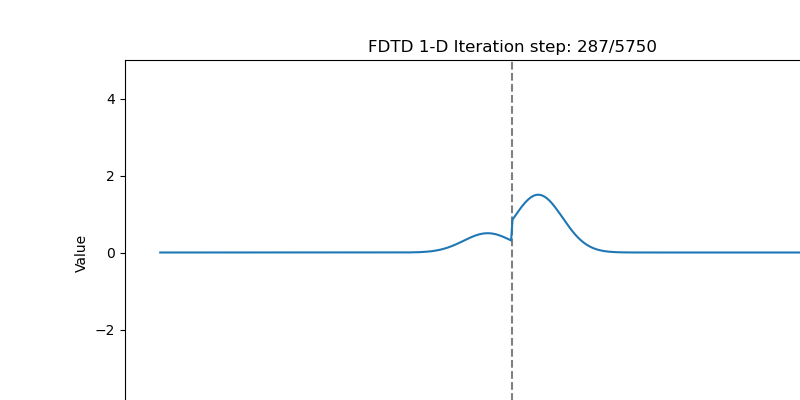

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-17-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

KeyboardInterrupt: 

In [17]:
#Plotting the field values....
%matplotlib notebook
fig = plt.figure(1,[10,5])
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,N_t):
    lineE = E_plot[i,:]
    #lineH = H_norm_plot[i,:]
    ax.clear()
    #plt.legend(handles = [lineE,lineH],labels=["Electric Field","Magnetic Field"])
    plt.ylabel('Value')
    plt.axvline(x=injection_point, color = "grey", linestyle="--")
    plt.ylim(-5,5)
    plt.xlabel('z (Space)')
    #plt.ylimit([-3,3])/
    plt.title(f'FDTD 1-D Iteration step: {i}/{N_t}')
    ax.plot(lineE)
    #ax.plot(lineH)
    fig.canvas.draw()
    #plt.savefig(f"1d-fdtd{i}.jpeg")
    ax = plt.axes()
    